In [1]:
import csv
import pandas as pd

# Import dataframes
df = pd.read_csv(open('11-19-2021 11pm ET/df_merged.csv'))
print(df.columns)
holc_grade = pd.read_csv(open('ACS/holc_grade_csv.csv'))
print(holc_grade.columns)

Index(['Unnamed: 0', 'Name', 'Wait Time', 'Delivery Fee', 'Link',
       'Delivery Address', 'Geoid', 'Unnamed: 0.1', 'Countyfp', 'Blkgrpce',
       'Funcstat', 'Latitude', 'Longitude', 'Mtfcc', 'Namelsad', 'Statefp',
       'Tractce', 'Aland', 'Awater', 'Latitude.1', 'Longitude.1',
       'Accuracy Score', 'Accuracy Type', 'Number', 'Street', 'Unit Type',
       'Unit Number', 'City', 'State', 'County', 'Zip', 'Country', 'Source'],
      dtype='object')
Index(['County Cod', 'State Code', 'Census Tra', 'Geoid', 'Holc Grade',
       'Holc Id', 'Id', 'Map Id', 'Msamd', 'Municipali', 'Name', 'Polygon Id',
       'St Name', 'State', 'Year', 'Geometry', 'Holc Area', 'Holc Prop',
       'Sheets', 'Tract Prop'],
      dtype='object')


#### Keep geoid and holc grade cols from holc_grade_csv.csv (encoding error in holc_grade.csv)

In [165]:
holc_grade = holc_grade.loc[:,holc_grade.columns.isin(['Geoid','Holc Grade'])]
# df = df.rename(columns={'$a':'a'})
holc_grade.rename(columns={'Geoid':'Tract Geoid'}, inplace=True)
print(holc_grade.head())

   Tract Geoid Holc Grade
0   6001421200          B
1   6001402500          D
2   6001423602          B
3   6001400400          B
4   6001421200          B


#### Keep 'Name', 'Wait Time', 'Delivery Fee', 'Delivery Address', 'Geoid', 'Blkgrpce' from joined_wDistance
divide geoid value by 10 to get tract geoid

In [307]:
df = df.loc[:, df.columns.isin(['Name', 'Wait Time', 'Delivery Fee', 'Delivery Address', 'Geoid'])]
df['Tract Geoid'] = df['Geoid']//10
print(df.head())

                                            Name  Wait Time  Delivery Fee  \
0                     Philly's Best (Jingletown)        NaN          4.99   
1                Burger Latino (5333 Adeline St)  35–45 min          3.99   
2  Philly Fresh Cheesesteaks (5333 Adeline St ,)  35–45 min          3.99   
3                         Dirty Burger (Oakland)  45–55 min          4.99   
4              iLava Hawaiian Barbecue (Adeline)  35–45 min          3.99   

            Delivery Address        Geoid  Tract Geoid  
0  2236 Linden St Oakland CA  60014016002   6001401600  
1  2236 Linden St Oakland CA  60014016002   6001401600  
2  2236 Linden St Oakland CA  60014016002   6001401600  
3  2236 Linden St Oakland CA  60014016002   6001401600  
4  2236 Linden St Oakland CA  60014016002   6001401600  


### How many unique tract geoids are there in the joined dataframe/HOLC grade data?

In [308]:
print(len(np.unique(df['Tract Geoid'])), "in joined df")
print(len(np.unique(holc_grade['Tract Geoid'])), "in HOLC data")

137 in joined df
175 in HOLC data


### Join tract geoids with one HOLC grade to main dataframe

## General strategy
#### "One-entry" tract geoids are geoids with exactly one entry in the holc_grade csv, or geoids with duplicate entries with identical HOLC grades. One-entry tract geoids have their respective HOLC grades in the 'Holc Grade' column. 

#### "Multi-grade" tract geoids have more than one entry in the holc_grade csv, with different HOLC grades for different entries. Multi-grade tract geoids have a list of grades in the 'Holc Grade' column.

In [309]:
# isolate one_entry geoids from holc_grades
# one_entry geoids are duplicates with identical HOLC scores, or geoids with exactly one entry
holc_grade_no_dup = holc_grade.drop_duplicates()
one_grade = [geoid for geoid in holc_grade_no_dup['Tract Geoid'] 
               if len(holc_grade_no_dup[holc_grade_no_dup['Tract Geoid'] == geoid]) == 1]
print(len(one_grade), "tract geoids have exactly one HOLC grade")
# get grades for one-entry geoids
one_grade_data = holc_grade_no_dup[holc_grade_no_dup['Tract Geoid'].isin(one_grade)]
# join one-entry geoids to main dataframe
joined_df = df.join(one_grade_data.set_index('Tract Geoid'), on='Tract Geoid', how='left')

60 tract geoids have exactly one HOLC grade


In [310]:
# Sanity check - confirm NaN value for HOLC grade for a multi-grade geoid
joined_df[joined_df['Tract Geoid'] == 6001407600]

,Name,Wait Time,Delivery Fee,Delivery Address,Geoid,Tract Geoid,Holc Grade
4313,Philly's Best (Jingletown),NaN,3.99,4500 Ellen St Oakland CA,60014076005,6001407600,NaN
4314,OSHA Thai Express (Oakland),45–55 min,4.99,4500 Ellen St Oakland CA,60014076005,6001407600,NaN
4315,iLava Hawaiian Barbecue (Adeline),40–50 min,6.99,4500 Ellen St Oakland CA,60014076005,6001407600,NaN
4316,Toasty's Breakfast Burritos (Oakland),50–60 min,3.99,4500 Ellen St Oakland CA,60014076005,6001407600,NaN
4317,"Philly Fresh Cheesesteaks (5333 Adeline St ,)",45–55 min,6.99,4500 Ellen St Oakland CA,60014076005,6001407600,NaN
...,...,...,...,...,...,...,...
13439,"Los Cantaros Taqueria -Emeryville, CA",40–50 min,7.99,4716 Fairfax Ave Oakland CA,60014076002,6001407600,NaN
13440,Cheese Steak Shop - Oakland,30–40 min,4.99,4716 Fairfax Ave Oakland CA,60014076002,6001407600,NaN
13441,Ikaros Greek Restaurant,40–50 min,3.99,4716 Fairfax Ave Oakland CA,60014076002,6001407600,NaN
13442,Tasty Pot - Berkeley,55–65 min,7.99,4716 Fairfax Ave Oakland CA,60014076002,6001407600,NaN


### For tract geoids with more than one HOLC grade, convert to a list of grades to add to df

In [311]:
print(len(np.unique(multi_grade)), "tract geoids have more than one HOLC grade")

115 tract geoids have more than one HOLC grade


In [312]:
# Sanity check 
print(np.unique(holc_grade[holc_grade['Tract Geoid'] == 6001423700]['Holc Grade']))
print(joined_df.loc[joined_df['Tract Geoid'] == 6001423700, 'Holc Grade'])

['A' 'B' 'C']
40910    NaN
40911    NaN
40912    NaN
40913    NaN
40914    NaN
        ... 
42583    NaN
42584    NaN
42585    NaN
42586    NaN
42587    NaN
Name: Holc Grade, Length: 328, dtype: object


In [313]:
multi_grade = [geoid for geoid in holc_grade['Tract Geoid']
              if geoid not in one_grade]
print(len(np.unique(multi_grade)), "tract geoids with more than one HOLC grade")

# Add list of grades to HOLC grade for multi-grade geoids
for geoid in multi_grade:
    grades = np.unique(holc_grade[holc_grade['Tract Geoid'] == geoid]['Holc Grade'])
    joined_df.loc[joined_df['Tract Geoid'] == geoid, 'Holc Grade'] = ', '.join(grades)

115 tract geoids with more than one HOLC grade


In [314]:
# Sanity check - multi-grade geoid is populated with a list of grades
print(joined_df.loc[joined_df['Tract Geoid'] == 6001423700, 'Holc Grade'])
print(len(joined_df.loc[joined_df['Holc Grade'].str.len() > 1]), "entries with more than one HOLC grade")
print(len(joined_df.loc[joined_df['Holc Grade'].str.len() == 1]), "entries with exactly one HOLC grade")

40910    A, B, C
40911    A, B, C
40912    A, B, C
40913    A, B, C
40914    A, B, C
          ...   
42583    A, B, C
42584    A, B, C
42585    A, B, C
42586    A, B, C
42587    A, B, C
Name: Holc Grade, Length: 328, dtype: object
29681 entries with more than one HOLC grade
13824 entries with exactly one HOLC grade


### Join ACS demographic data on block group Geoid

In [315]:
demo_df = pd.read_csv(open('ACS/acs_demographic_data.csv'))
demo_df = demo_df.loc[:, demo_df.columns.isin(['pct_white',
       'pct_black', 'pct_native', 'pct_asian', 'pct_hisp', 'pct_other',
       'median_income', 'pct_college', 'pct_hs_grad', 'pct_device_access',
       'pct_internet_access', 'GEOID'])]
demo_df.rename(columns={"GEOID":"Geoid"}, inplace=True)
df = joined_df.join(demo_df.set_index('Geoid'), on='Geoid', how='left')
print("Final DataFrame columns: \n", list(df.columns))

Final DataFrame columns: 
 ['Name', 'Wait Time', 'Delivery Fee', 'Delivery Address', 'Geoid', 'Tract Geoid', 'Holc Grade', 'pct_white', 'pct_black', 'pct_native', 'pct_asian', 'pct_hisp', 'pct_other', 'median_income', 'pct_college', 'pct_hs_grad', 'pct_device_access', 'pct_internet_access']


# Data Exploration
Initial questions:
- What are the min, max, & avg delivery fees for addresses in highest & lowest HOLC grade areas?
- Same question for tracts with *any* "hazardous" graded areas relative to those with none

####  What are the min, max, & avg delivery fees for addresses in areas with each HOLC grade?

In [434]:
holc_grades = ['A', 'B', 'C', 'D']
fee_info = {'max':[np.NaN, np.NaN, np.NaN, np.NaN], 
            'min':[np.NaN, np.NaN, np.NaN, np.NaN],
            'avg':[np.NaN, np.NaN, np.NaN, np.NaN]}
for grade in holc_grades:
    # Isolate one grade
    var = str(grade + 'grade')
    var = df[df['Holc Grade'] == grade]
    # Min, max, avg delivery fees for each
    fee_info['max'][holc_grades.index(grade)] = max(var['Delivery Fee'])
    fee_info['min'][holc_grades.index(grade)] = min(var['Delivery Fee'])
    fee_info['avg'][holc_grades.index(grade)] = round(np.mean(var['Delivery Fee']), 2)
    print("Delivery address in area with", grade, "Grade")
    print("max: ", max(var['Delivery Fee']))
    print("min: ", min(var['Delivery Fee']))
    print("mean: ", round(np.mean(var['Delivery Fee']), 2))

Delivery address in area with A Grade
max:  13.99
min:  0.99
mean:  4.76
Delivery address in area with B Grade
max:  14.49
min:  0.99
mean:  4.92
Delivery address in area with C Grade
max:  14.49
min:  0.49
mean:  4.19
Delivery address in area with D Grade
max:  14.49
min:  0.0
mean:  4.23


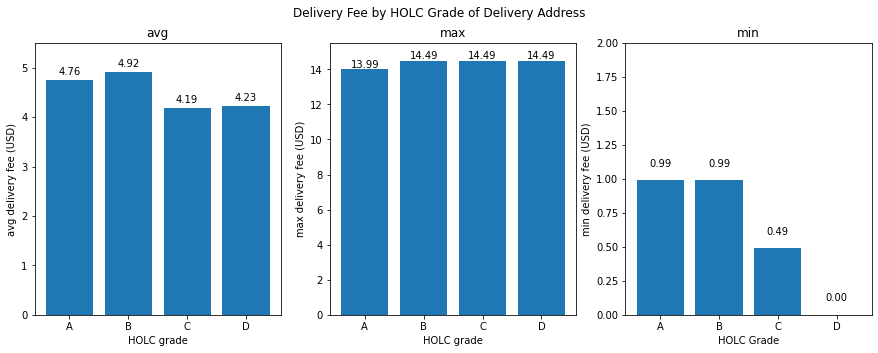

In [435]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True)
for ax_n, stat in zip([0,1,2], ['avg', 'max', 'min']):
    ax[ax_n].bar(holc_grades, fee_info[stat])
    for i, v in enumerate(fee_info[stat]):
        ax[ax_n].text(i, v+.1, "%.2f" %v, ha="center")
    ax[ax_n].set_ylabel(stat + " delivery fee (USD)")
    ax[ax_n].set_xlabel("HOLC grade")
    ax[ax_n].set_title(stat)
ax[0].set_ylim(0, 5.5)
ax[1].set_ylim(0, 15.5)
ax[2].set_ylim(0, 2)
plt.suptitle("Delivery Fee by HOLC Grade of Delivery Address")
plt.xlabel("HOLC Grade")

plt.show()

####  What are the min, max, & avg delivery fees  for tracts with *any* "hazardous" graded areas relative to those with none?

In [475]:
# Delivery addresses in tracts with any D-graded areas
any_d = df[df['Holc Grade'].str.contains('D')==True]
no_d = df[df['Holc Grade'].str.contains('D')==False]

# Sanity check - which grades are included in each group
# print(np.unique(any_d['Holc Grade']))
# print(np.unique(no_d['Holc Grade']))

d_fee_info = {'max':[np.NaN, np.NaN], 
             'min':[np.NaN, np.NaN],
             'avg':[np.NaN, np.NaN]}
d_fee_info['max'] = [max(any_d['Delivery Fee']), max(no_d['Delivery Fee'])]
d_fee_info['min'] = [min(any_d['Delivery Fee']), min(no_d['Delivery Fee'])]
d_fee_info['avg'] = [round(np.mean(any_d['Delivery Fee']), 2), round(np.mean(no_d['Delivery Fee']), 2)]

# Min, max, avg delivery fees for each
print("Delivery address in area with at least some D Graded region(s)")
print("max: ", max(any_d['Delivery Fee']))
print("min: ", min(any_d['Delivery Fee']))
print("mean: ", round(np.mean(any_d['Delivery Fee']), 2))

print("Delivery address in area with no D Graded region(s)")
print("max: ", max(no_d['Delivery Fee']))
print("min: ", min(no_d['Delivery Fee']))
print("mean: ", round(np.mean(no_d['Delivery Fee']), 2))

Delivery address in area with at least some D Graded region(s)
max:  14.49
min:  0.0
mean:  4.37
Delivery address in area with no D Graded region(s)
max:  14.99
min:  0.49
mean:  4.21


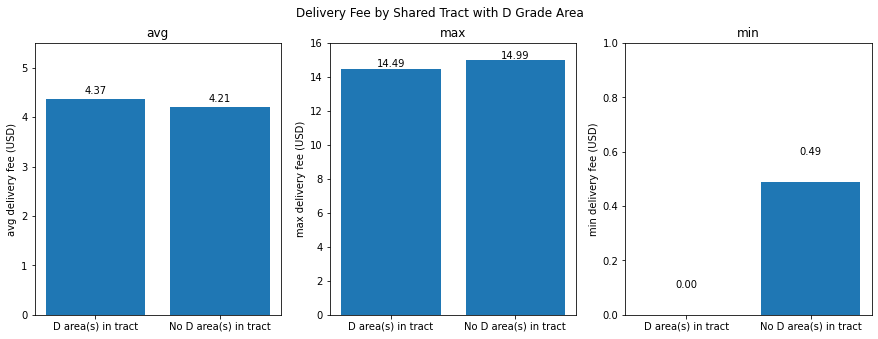

In [490]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15,5))
holc_groups = ["D area(s) in tract", "No D area(s) in tract"]
for ax_n, stat in zip([0,1,2], ['avg', 'max', 'min']):
    ax[ax_n].bar(holc_groups, d_fee_info[stat])
    for i, v in enumerate(d_fee_info[stat]):
        ax[ax_n].text(i, v+.1, "%.2f" %v, ha="center")
    ax[ax_n].set_ylabel(stat + " delivery fee (USD)")
    ax[ax_n].set_title(stat)
ax[0].set_ylim(0, 5.5)
ax[1].set_ylim(0, 16)
ax[2].set_ylim(0, 1)
plt.suptitle("Delivery Fee by Shared Tract with D Grade Area")
plt.show()